In [2]:
import numpy as np
import awkward as ak
import hist
import warnings
import pickle
from coffea.ml_tools.torch_wrapper import torch_wrapper
import matplotlib.pyplot as plt
import hist
from sklearn.metrics import roc_curve, auc
import math
import os
import uproot
import json

In [3]:
warnings.filterwarnings('ignore', 'invalid value')
warnings.filterwarnings('ignore', 'No format')

In [4]:
hgg = ak.from_parquet('/scratch365/cmoore24/training/data/ecfs/hgg_ecfs.parquet')

In [5]:
qcd = ak.firsts(ak.from_parquet('/scratch365/cmoore24/training/data/ecfs/qcd_ecfs.parquet'))

In [6]:
hgg = hgg[ak.flatten(hgg.msoftdrop < 200)]
hgg = hgg[ak.flatten(hgg.msoftdrop > 40)]
hgg = hgg[ak.flatten(hgg.pt < 600)]
hgg = hgg[ak.flatten(hgg.pt > 450)]

In [7]:
qcd = qcd[qcd.msoftdrop < 200]
qcd = qcd[qcd.msoftdrop > 40]
qcd = qcd[qcd.pt < 600]
qcd = qcd[qcd.pt > 450]

In [8]:
mask = ak.ones_like(hgg[hgg.fields[0]], dtype='bool')
mask = ak.fill_none(mask, True)
for j in hgg.fields:
    if hgg[j].fields == []:
        mask = mask & (~ak.is_none(ak.nan_to_none(hgg[j])))
    else:
        for i in hgg[j].fields:
            mask = mask & (~ak.is_none(ak.nan_to_none(hgg[j][i])))
hgg = hgg[ak.flatten(mask)]

In [9]:
mask = ak.ones_like(qcd[qcd.fields[0]], dtype='bool')
mask = ak.fill_none(mask, True)
for j in qcd.fields:
    if qcd[j].fields == []:
        mask = mask & (~ak.is_none(ak.nan_to_none(qcd[j])))
    else:
        for i in qcd[j].fields:
            mask = mask & (~ak.is_none(ak.nan_to_none(qcd[j][i])))
qcd = qcd[mask]

In [15]:
with open('/scratch365/cmoore24/training/hgg/binary/ecfs_project/combo_training/trained_ratios.pkl', 'rb') as f:
    items = pickle.load(f)

In [17]:
def add_ratio(ratio, dataframe):
    dash = ratio.find('/')
    asterisk = ratio.find('*')
    numerator = ratio[:dash]
    denominator = ratio[dash+1:asterisk]
    exponent = float(ratio[asterisk+2:])
    num_ecf = dataframe[numerator]
    den_ecf = dataframe[denominator]
    ecf_ratio = (num_ecf)/(den_ecf**exponent)
    return ecf_ratio

In [18]:
hgg_ratios = {}
for i in items:
    hgg_ratios[i] = add_ratio(i, hgg.ECFs)

In [19]:
qcd_ratios = {}
for i in items:
    qcd_ratios[i] = add_ratio(i, qcd.ECFs)

In [20]:
hgg_train = ak.zip({
    'd2b1': hgg.d2b1,
    'ECFs': hgg.ECFs,
    'msoftdrop': hgg.msoftdrop,
    'pt': hgg.pt,
    'ratios': ak.Array(hgg_ratios),
},
       depth_limit=1
      )

In [21]:
qcd_train = ak.zip({
    'd2b1': qcd.d2b1,
    'ECFs': qcd.ECFs,
    'msoftdrop': qcd.msoftdrop,
    'pt': qcd.pt,
    'ratios': ak.Array(qcd_ratios),
},
       depth_limit=1
      )

In [22]:
model = f'/scratch365/cmoore24/training/hgg/binary/ecfs_project/combo_training/test_traced_model.pt'

In [23]:
scaler = f'/scratch365/cmoore24/training/hgg/binary/ecfs_project/combo_training/test_scaler.pkl'
with open(scaler, 'rb') as f:
    scaler = pickle.load(f)

In [28]:
def imapper(array, ratio_list):
    imap = {}
    imap['vars'] = {}
    for i in ratio_list:
        imap['vars'][i] = array.ratios[i]
    return imap

In [33]:
class EnergyCorrelatorFunctionTagger(torch_wrapper):
    def prepare_awkward(self, events, scaler, imap):
        fatjets = events

        retmap = {
            k: ak.concatenate([x[:, np.newaxis] for x in imap[k].values()], axis=1)
            for k in imap.keys()
        }
        x = ak.values_astype(scaler.transform(retmap['vars']), "float32")
        return (x,), {}

In [34]:
tagger = EnergyCorrelatorFunctionTagger(model)

In [35]:
hgg_imap = imapper(hgg_train, items)
hgg_scores = tagger(hgg_train, scaler, hgg_imap)[:,0]

In [36]:
qcd_imap = imapper(qcd_train, items)
qcd_scores = tagger(qcd_train, scaler, qcd_imap)[:,0]

In [37]:
up = max(ak.max(hgg_scores), ak.max(qcd_scores))
up

4.3091745

In [38]:
down = min(ak.min(hgg_scores), ak.min(qcd_scores))
down

-503.62164

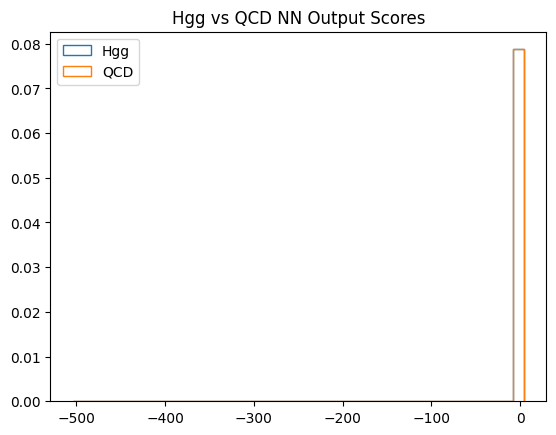

In [39]:
pltrange = (down, up)
plt.hist(hgg_scores, bins=40, histtype='step', label='Hgg', density=True, range=pltrange)
plt.hist(qcd_scores, bins=40, histtype='step', label='QCD', density=True, range=pltrange)
plt.title(f'Hgg vs QCD NN Output Scores')
plt.legend()
plt.show()

In [40]:
mask = ~np.isnan(qcd_scores)
qcd_scores = qcd_scores[mask]
qcd_train = qcd_train[mask]

In [41]:
mask = ~np.isnan(hgg_scores)
hgg_scores = hgg_scores[mask]
hgg_train = hgg_train[mask]

In [42]:
bkg_zeros = ak.zeros_like(qcd_scores)
sig_ones = ak.ones_like(hgg_scores)
combined = ak.concatenate([qcd_scores,hgg_scores])
combined_truth = ak.concatenate([bkg_zeros, sig_ones])

In [43]:
fpr, tpr, thresholds = roc_curve(combined_truth, combined)
roc_auc = auc(fpr, tpr)

In [44]:
hrange=(np.floor(ak.min(qcd_scores)), np.ceil(ak.max(qcd_scores)))
hrange

(-504.0, 5.0)

In [45]:
hgg_hist = np.histogram(hgg_scores, bins=20,
                range=hrange
                )
qcd_hist = np.histogram(qcd_scores, bins=20, 
                 range=hrange
                )

In [46]:
sig_sums = []
for i in range(len(hgg_hist[0])+1):
    sig_sums.append(sum(hgg_hist[0][len(hgg_hist[0])-i:]))

bkg_sums = []
for i in range(len(qcd_hist[0])+1):
    bkg_sums.append(sum(qcd_hist[0][len(qcd_hist[0])-i:]))

In [47]:
sig_ratios = []
for i in sig_sums:
    sig_ratios.append(i/sig_sums[-1])
bkg_ratios = []
for i in bkg_sums:
    bkg_ratios.append(i/bkg_sums[-1])

In [48]:
wp_ratios = {}
for i in range(len(hgg_hist[1])):
    wp_ratios[str(hgg_hist[1][-i-1])] = [sig_ratios[i], bkg_ratios[i]]

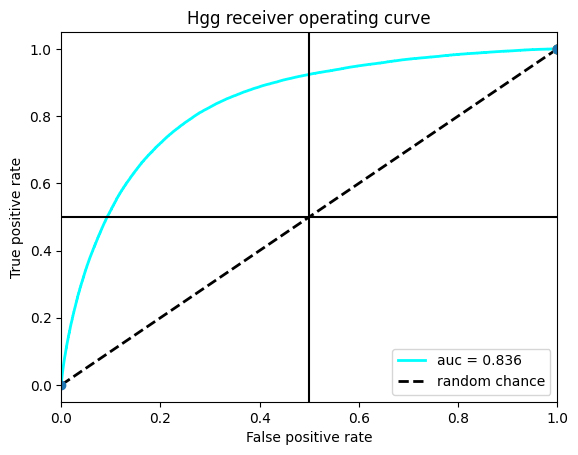

In [49]:
plt.plot(fpr, tpr, lw=2, color="cyan", label="auc = %.3f" % (roc_auc))
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle="--", lw=2, color="k", label="random chance")
plt.xlim([0, 1.0])
#     ax.set_ylim([1e-5, 1.0])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title(f"Hgg receiver operating curve")
plt.legend(loc="lower right")
plt.axvline(x=0.5, color='black')
plt.axhline(y=0.5, color='black')
for i in wp_ratios:
    plt.plot(wp_ratios[i][1], wp_ratios[i][0], 'o', label=f'WP = {str(i)}')
#plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [50]:
def get_cut(qcd_scores, break_val):
    hrange=(ak.min(qcd_scores), ak.max(qcd_scores))
    proportion=1.0
    i = 0
    while proportion > 0.15:
        qcd_hist = np.histogram(qcd_scores, bins=1000, 
                     range=hrange
                    )
        largest_bin_indices = np.argsort(qcd_hist[0])[-10:]
        largest_bin_vals = qcd_hist[1][largest_bin_indices]
        hrange = (largest_bin_vals[0], ak.max(qcd_scores))
        proportion = sum(qcd_hist[0])/len(qcd_scores)
        print(proportion)
        i += 1
        if i > break_val:
            break
    cumulative_distribution = np.cumsum(qcd_hist[0][min(largest_bin_indices):max(largest_bin_indices)])
    total_count = cumulative_distribution[-1]
    half_count = total_count / 2
    median_bin_index = np.where(cumulative_distribution >= half_count)[0][0]
    cut = qcd_hist[1][median_bin_index]
    return cut

In [51]:
cut = get_cut(qcd_scores, 100)
cut

1.0
0.9618089033183452
0.6523363649792933
0.6388838534912082
0.6127533238673035
0.5917665112243286
0.5717606302940605
0.5622938237650162
0.5458952551331154
0.53546615692391
0.5139942374339386
0.5000305230532932
0.48394650497059766
0.46329288290937354
0.43327823650380093
0.41505620668813686
0.40332743220969663
0.40021314877215775
0.38822434583970783
0.37135558238684685
0.36771984403884767
0.2282896045936496
0.22756730333251163
0.22756730333251163
0.22756730333251163
0.22756730333251163
0.22756730333251163
0.22756730333251163
0.22756730333251163
0.22756730333251163
0.22756730333251163
0.22756730333251163
0.22756730333251163
0.22756730333251163
0.22756730333251163
0.22756730333251163
0.22756730333251163
0.22756730333251163
0.22756730333251163
0.22756730333251163
0.22756730333251163
0.22756730333251163
0.22756730333251163
0.22756730333251163
0.22756730333251163
0.22756730333251163
0.22756730333251163
0.22756730333251163
0.22756730333251163
0.22756730333251163
0.22756730333251163
0.22756730

0.34495991468429565

In [52]:
mask = ~((qcd_scores > cut))
qcd_cut_msd = qcd_train.msoftdrop[mask]
qcd_fail_hist = hist.Hist.new.Reg(40, 40, 200, name='msd', label='QCD MSD').Weight()
qcd_fail_hist.fill(msd=qcd_cut_msd);

In [53]:
mask = ((qcd_scores > cut))
qcd_cut_msd = qcd_train.msoftdrop[mask]
qcd_pass_hist = hist.Hist.new.Reg(40, 40, 200, name='msd', label='QCD MSD').Weight()
qcd_pass_hist.fill(msd=qcd_cut_msd);

In [54]:
with open('../../jsons/subregion_event_totals.json', 'r') as f:
    totals = json.load(f)
with open('../../jsons/my_xsecs.json', 'r') as f:
    xsecs = json.load(f)

In [55]:
scale = ((44.99*(xsecs['qcd']['qcd_470to600']*1000))/totals['qcd']['470to600'])
qcd_pass_hist.view(flow=True)[:] *= scale
qcd_fail_hist.view(flow=True)[:] *= scale

In [56]:
total_qcd_hist = qcd_pass_hist + qcd_fail_hist

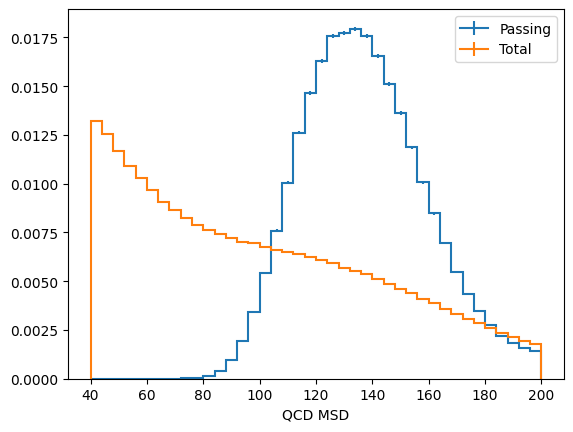

In [57]:
qcd_pass_hist.plot1d(density=True, label='Passing')
#qcd_fail_hist.plot1d(density=True, label='Failing')
total_qcd_hist.plot1d(density=True, label='Total')
plt.legend()
plt.show()

In [58]:
sum(qcd_pass_hist.values()), sum(total_qcd_hist.values())

(557314.7086128457, 2629171.387035137)

In [59]:
sum(qcd_pass_hist.values())/sum(total_qcd_hist.values())

0.21197351810576265

In [60]:
sculpt_metric = sum(abs(total_qcd_hist.density() - qcd_pass_hist.density()))

In [61]:
sculpt_metric

0.26817793375081184